# Lecture 02: Measuring Fairness - Bias Metrics

## Learning Objectives
- Understand and compute Demographic Parity
- Understand and compute Equalized Odds
- Use fairlearn to measure bias
- Recognize trade-offs between different fairness definitions
- Understand impossibility results in fairness

**Prerequisites:** Confusion matrix, TPR, FPR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# Install fairlearn if needed: pip install fairlearn
try:
    from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
    print('✓ fairlearn loaded successfully')
except:
    print('⚠️  fairlearn not installed. Run: pip install fairlearn')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

✓ fairlearn loaded successfully


## 1. Why We Need Metrics

**From Lecture 01:** We know ML systems can be biased.

**This Lecture:** How do we **measure** bias?

**Key Principle:** "You can't improve what you can't measure"

### Fairness Metrics Allow Us To:
1. **Detect** bias in deployed systems
2. **Quantify** how severe the bias is
3. **Compare** different models
4. **Track** changes over time
5. **Set** acceptable thresholds

### Group Fairness Metrics

Focus on **protected groups** (race, gender, age, etc.)

**Question:** Are outcomes similar across groups?

We'll cover the two most common:
1. **Demographic Parity** (DP)
2. **Equalized Odds** (EO)

## 2. Demographic Parity (Statistical Parity)

### Definition

**Demographic Parity:** Groups should receive positive outcomes at equal rates

**Mathematical:**
```
P(Ŷ=1 | A=0) = P(Ŷ=1 | A=1)
```

Where:
- Ŷ = prediction
- A = protected attribute (e.g., race)

**In words:** "Selection rate should be same for all groups"

### When to Use

✅ **Use when:**
- You want equal opportunity (college admissions, hiring)
- Base rates SHOULD be similar across groups
- Historical data is biased

❌ **Don't use when:**
- Groups have legitimately different base rates
- Example: Disease with different prevalence by age

### Example: Loan Approval

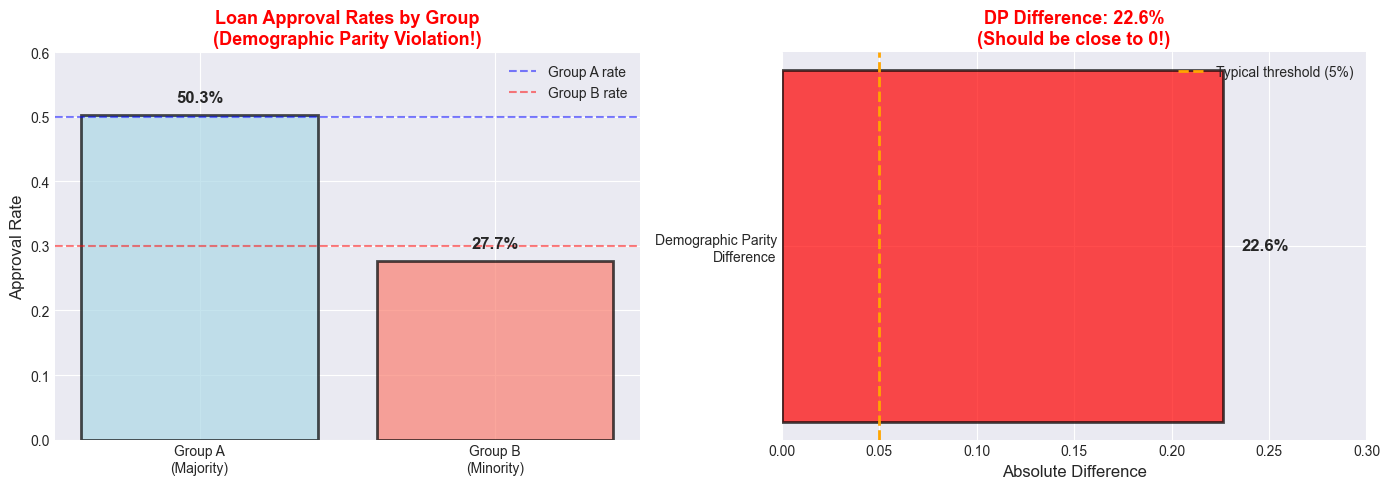


📊 Demographic Parity Analysis:
  Group A approval rate: 50.3%
  Group B approval rate: 27.7%
  DP Difference: 22.6%

⚠️  This violates Demographic Parity!
     Group B is 1.8x less likely to be approved


In [2]:
# Simulate loan approval data with bias
np.random.seed(42)
n = 1000

# Group A (majority)
n_A = 700
approved_A = np.random.binomial(1, 0.5, n_A)  # 50% approval rate
group_A = np.zeros(n_A)

# Group B (minority) - BIASED: lower approval rate
n_B = 300
approved_B = np.random.binomial(1, 0.3, n_B)  # 30% approval rate (BIAS!)
group_B = np.ones(n_B)

# Combine
predictions = np.concatenate([approved_A, approved_B])
groups = np.concatenate([group_A, group_B])

# Calculate selection rates
selection_rate_A = approved_A.mean()
selection_rate_B = approved_B.mean()
dp_diff = abs(selection_rate_A - selection_rate_B)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of approval rates
rates = [selection_rate_A, selection_rate_B]
axes[0].bar(['Group A\n(Majority)', 'Group B\n(Minority)'], rates, 
           color=['lightblue', 'salmon'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Approval Rate', fontsize=12)
axes[0].set_ylim(0, 0.6)
axes[0].set_title('Loan Approval Rates by Group\n(Demographic Parity Violation!)', 
                 fontsize=13, fontweight='bold', color='red')
axes[0].axhline(0.5, color='blue', linestyle='--', alpha=0.5, label='Group A rate')
axes[0].axhline(0.3, color='red', linestyle='--', alpha=0.5, label='Group B rate')
axes[0].legend()

# Add value labels
for i, rate in enumerate(rates):
    axes[0].text(i, rate + 0.02, f'{rate:.1%}', ha='center', 
                fontsize=12, fontweight='bold')

# Difference visualization
axes[1].barh(['Demographic Parity\nDifference'], [dp_diff], 
            color='red', alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xlabel('Absolute Difference', fontsize=12)
axes[1].set_xlim(0, 0.3)
axes[1].set_title(f'DP Difference: {dp_diff:.1%}\n(Should be close to 0!)', 
                 fontsize=13, fontweight='bold', color='red')
axes[1].axvline(0.05, color='orange', linestyle='--', linewidth=2, 
               label='Typical threshold (5%)')
axes[1].legend()
axes[1].text(dp_diff + 0.01, 0, f'{dp_diff:.1%}', va='center', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Demographic Parity Analysis:")
print(f"  Group A approval rate: {selection_rate_A:.1%}")
print(f"  Group B approval rate: {selection_rate_B:.1%}")
print(f"  DP Difference: {dp_diff:.1%}")
print(f"\n⚠️  This violates Demographic Parity!")
print(f"     Group B is {selection_rate_A/selection_rate_B:.1f}x less likely to be approved")

### Demographic Parity Formula

**DP Difference:**
```python
DP_diff = |P(Ŷ=1 | A=0) - P(Ŷ=1 | A=1)|
```

**Interpretation:**
- **DP_diff = 0:** Perfect demographic parity
- **DP_diff < 0.05:** Often acceptable (5% threshold)
- **DP_diff > 0.10:** Significant bias

**80% Rule (EEOC):**
```python
ratio = P(Ŷ=1 | A=minority) / P(Ŷ=1 | A=majority)
```
- Should be ≥ 0.8 (80%)
- Otherwise: Adverse impact

## 3. Equalized Odds

### Motivation

**Problem with DP:** Ignores ground truth!

**Question:** What if groups have different true base rates?

**Example:** 
- Disease X has 10% prevalence in elderly, 2% in young
- Demographic parity would require equal diagnosis rates (wrong!)
- Need metric that conditions on true outcome

### Definition

**Equalized Odds:** Error rates should be equal across groups

**Mathematical:**
```
P(Ŷ=1 | Y=y, A=0) = P(Ŷ=1 | Y=y, A=1)  for y ∈ {0,1}
```

**In words:**
- **TPR (True Positive Rate)** should be equal across groups
- **FPR (False Positive Rate)** should be equal across groups

**Also called:** Separation, Error Rate Parity

### When to Use

✅ **Use when:**
- Groups have different base rates (legitimately)
- Prediction quality matters (medical diagnosis, risk assessment)
- Want equal treatment of true positives AND true negatives

### Example: Medical Diagnosis

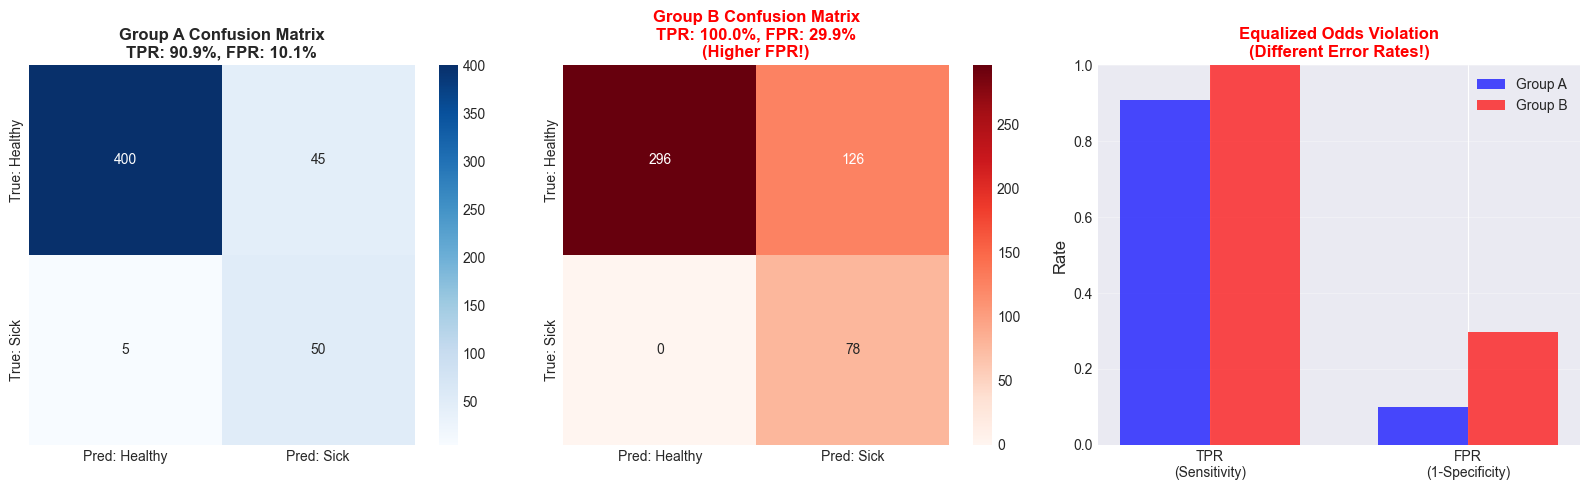


📊 Equalized Odds Analysis:

Group A:
  TPR (sensitivity): 90.9%
  FPR: 10.1%

Group B:
  TPR (sensitivity): 100.0%
  FPR: 29.9%

Differences:
  TPR difference: 9.1%
  FPR difference: 19.7%

⚠️  Equalized Odds violation: Group B has much higher FPR!
     (More false diagnoses for Group B)


In [3]:
# Simulate medical diagnosis with bias in error rates
np.random.seed(42)

def generate_biased_predictions(y_true, group, bias_factor=0.3):
    """Generate predictions with group-based bias in error rates"""
    y_pred = y_true.copy()
    
    if group == 'B':  # Introduce bias for Group B
        # Higher false positive rate
        healthy = np.where(y_true == 0)[0]
        fp_indices = np.random.choice(healthy, int(len(healthy) * bias_factor), replace=False)
        y_pred[fp_indices] = 1
    else:  # Group A: normal error rate
        # Some random errors
        errors = np.random.choice(len(y_true), int(len(y_true) * 0.1), replace=False)
        y_pred[errors] = 1 - y_pred[errors]
    
    return y_pred

# Group A
n_A = 500
y_true_A = np.random.binomial(1, 0.1, n_A)  # 10% disease rate
y_pred_A = generate_biased_predictions(y_true_A, 'A')

# Group B (different base rate, AND biased predictions)
n_B = 500
y_true_B = np.random.binomial(1, 0.15, n_B)  # 15% disease rate (legitimately different)
y_pred_B = generate_biased_predictions(y_true_B, 'B', bias_factor=0.3)

# Compute confusion matrices
cm_A = confusion_matrix(y_true_A, y_pred_A)
cm_B = confusion_matrix(y_true_B, y_pred_B)

# Compute TPR and FPR
tpr_A = cm_A[1,1] / (cm_A[1,1] + cm_A[1,0]) if (cm_A[1,1] + cm_A[1,0]) > 0 else 0
fpr_A = cm_A[0,1] / (cm_A[0,1] + cm_A[0,0]) if (cm_A[0,1] + cm_A[0,0]) > 0 else 0

tpr_B = cm_B[1,1] / (cm_B[1,1] + cm_B[1,0]) if (cm_B[1,1] + cm_B[1,0]) > 0 else 0
fpr_B = cm_B[0,1] / (cm_B[0,1] + cm_B[0,0]) if (cm_B[0,1] + cm_B[0,0]) > 0 else 0

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Confusion matrix A
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Pred: Healthy', 'Pred: Sick'],
           yticklabels=['True: Healthy', 'True: Sick'])
axes[0].set_title(f'Group A Confusion Matrix\nTPR: {tpr_A:.1%}, FPR: {fpr_A:.1%}', 
                 fontsize=12, fontweight='bold')

# Confusion matrix B
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Reds', ax=axes[1],
           xticklabels=['Pred: Healthy', 'Pred: Sick'],
           yticklabels=['True: Healthy', 'True: Sick'])
axes[1].set_title(f'Group B Confusion Matrix\nTPR: {tpr_B:.1%}, FPR: {fpr_B:.1%}\n(Higher FPR!)', 
                 fontsize=12, fontweight='bold', color='red')

# Error rate comparison
x = np.arange(2)
width = 0.35
axes[2].bar(x - width/2, [tpr_A, fpr_A], width, label='Group A', color='blue', alpha=0.7)
axes[2].bar(x + width/2, [tpr_B, fpr_B], width, label='Group B', color='red', alpha=0.7)
axes[2].set_ylabel('Rate', fontsize=12)
axes[2].set_title('Equalized Odds Violation\n(Different Error Rates!)', 
                 fontsize=12, fontweight='bold', color='red')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['TPR\n(Sensitivity)', 'FPR\n(1-Specificity)'])
axes[2].legend()
axes[2].set_ylim(0, 1)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Equalized Odds Analysis:")
print(f"\nGroup A:")
print(f"  TPR (sensitivity): {tpr_A:.1%}")
print(f"  FPR: {fpr_A:.1%}")
print(f"\nGroup B:")
print(f"  TPR (sensitivity): {tpr_B:.1%}")
print(f"  FPR: {fpr_B:.1%}")
print(f"\nDifferences:")
print(f"  TPR difference: {abs(tpr_A - tpr_B):.1%}")
print(f"  FPR difference: {abs(fpr_A - fpr_B):.1%}")
print(f"\n⚠️  Equalized Odds violation: Group B has much higher FPR!")
print(f"     (More false diagnoses for Group B)")

### Equalized Odds Formula

**EO requires BOTH:**

1. **Equal TPR (True Positive Rate):**
```python
TPR_A = TP_A / (TP_A + FN_A)
TPR_B = TP_B / (TP_B + FN_B)
|TPR_A - TPR_B| ≈ 0
```

2. **Equal FPR (False Positive Rate):**
```python
FPR_A = FP_A / (FP_A + TN_A)
FPR_B = FP_B / (FP_B + TN_B)
|FPR_A - FPR_B| ≈ 0
```

**Interpretation:**
- Sick people should be caught equally (equal TPR)
- Healthy people should NOT be mislabeled equally (equal FPR)

## 4. Using fairlearn

### Microsoft's Fairness Toolkit

**fairlearn** provides:
- Pre-built fairness metrics
- Disaggregated metric computation
- Mitigation algorithms
- Visualizations

**Installation:**
```bash
pip install fairlearn
```


📊 Metrics by Group:

                     accuracy  precision    recall  selection_rate
sensitive_feature_0                                               
0                    1.000000   1.000000  1.000000        0.275613
1                    0.700326   0.517483  0.762887        0.465798

📊 Metric Differences:

accuracy          0.299674
precision         0.482517
recall            0.237113
selection_rate    0.190185
dtype: float64

📊 Fairness Metrics:
  Demographic Parity Difference: 0.190
  Equalized Odds Difference: 0.329


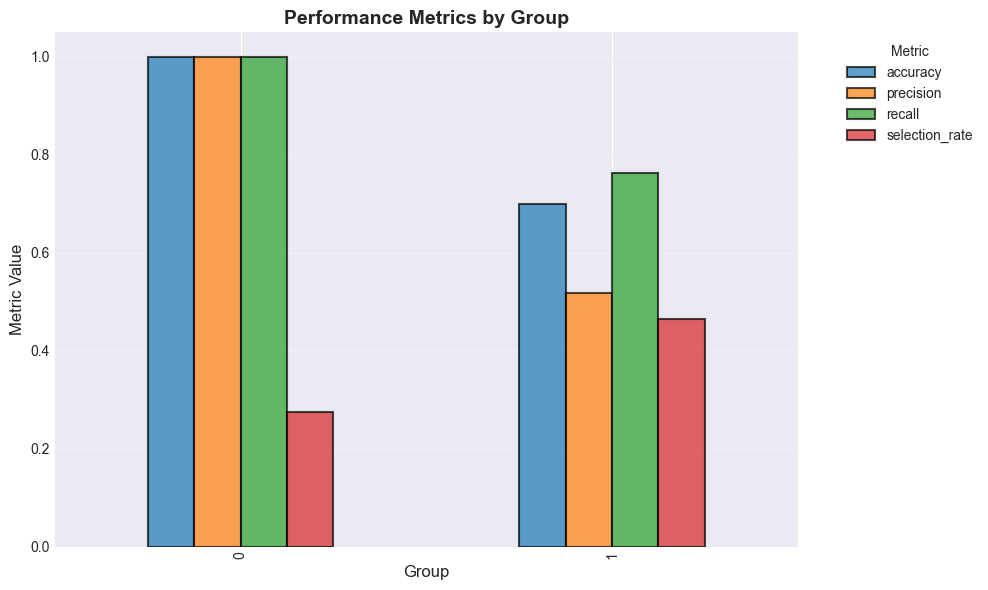


💡 fairlearn makes it easy to:
   1. Compute metrics by group
   2. Calculate fairness differences
   3. Visualize disparities


In [4]:
# Using fairlearn to compute metrics
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import selection_rate
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Create sample data
np.random.seed(42)
n = 1000
y_true = np.random.binomial(1, 0.3, n)
y_pred = y_true.copy()

# Add bias: worse performance for group 1
sensitive_features = np.random.binomial(1, 0.3, n)
group_1_idx = np.where(sensitive_features == 1)[0]
errors = np.random.choice(group_1_idx, int(len(group_1_idx) * 0.3), replace=False)
y_pred[errors] = 1 - y_pred[errors]

# Compute metrics by group using MetricFrame
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate,
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

print("\n📊 Metrics by Group:\n")
print(metric_frame.by_group)

print("\n📊 Metric Differences:\n")
print(metric_frame.difference())

# Fairness metrics
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)

print(f"\n📊 Fairness Metrics:")
print(f"  Demographic Parity Difference: {dp_diff:.3f}")
print(f"  Equalized Odds Difference: {eo_diff:.3f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
metric_frame.by_group.plot(kind='bar', ax=ax, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_title('Performance Metrics by Group', fontsize=14, fontweight='bold')
ax.set_xlabel('Group', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n💡 fairlearn makes it easy to:")
print("   1. Compute metrics by group")
print("   2. Calculate fairness differences")
print("   3. Visualize disparities")

## 5. The Impossibility of Perfect Fairness

### Key Theoretical Result

**You cannot simultaneously satisfy:**
1. Demographic Parity
2. Equalized Odds
3. Predictive Parity (Precision equality)

**...except in trivial cases!**

### Why This Matters

**Implication:** Fairness always involves **trade-offs**

**Must choose:**
- Which fairness definition matters most?
- How much can we sacrifice?
- What context demands?

### Example Tension

**Scenario:** College admissions

**Demographic Parity says:** Admit same % from each group

**Equalized Odds says:** Among qualified students, admit same % from each group

**If groups have different qualifications (due to historical inequality):**
- Can't satisfy both!
- Must choose which matters more
- Or find compromise

## Summary

### Key Metrics

**1. Demographic Parity**
- Equal selection rates across groups
- Ignores ground truth
- Use for: Hiring, admissions, equal opportunity

**2. Equalized Odds**
- Equal TPR and FPR across groups
- Conditions on ground truth
- Use for: Risk assessment, diagnosis, predictions


### Trade-offs

- **No perfect fairness** - must choose which definition
- **Context matters** - different applications need different metrics
- **Stakeholders decide** - technical measurement, values-based choice

### Next Steps

**Lecture 03:** How to explain individual predictions (LIME, SHAP)

**Lecture 04:** Responsible AI practices (privacy, documentation)

**Lab:** Measure bias on COMPAS and Adult datasets!

In [6]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import pandas as pd
y_true = [1,1,1,1,1,0,0,1,1,0]
y_pred = [0,1,1,1,1,0,0,0,1,1]
sex = ['Female']*5 + ['Male']*5
metrics = {"selection_rate": selection_rate}
mf1 = MetricFrame(
     metrics=metrics,
     y_true=y_true,
     y_pred=y_pred,
     sensitive_features=sex)

In [7]:
mf1.by_group 

,selection_rate
sensitive_feature_0,
Female,0.8
Male,0.4


In [8]:
print(f"difference: {mf1.difference()[0]:.3}   "
     f"ratio: {mf1.ratio()[0]:.3}   "
     f"max across groups: {mf1.group_max()[0]:.3}")

difference: 0.4   ratio: 0.5   max across groups: 0.8


In [9]:
metrics_dict = {"accuracy":accuracy_score, "selection_rate": selection_rate}
mf2 = MetricFrame(
     metrics=metrics_dict,
     y_true=y_true,
     y_pred=y_pred,
     sensitive_features=sex)

In [10]:
mf2.by_group 

,accuracy,selection_rate
sensitive_feature_0,,
Female,0.8,0.8
Male,0.6,0.4


In [11]:
mf2.difference()

accuracy          0.2
selection_rate    0.4
dtype: float64